# Deep Neural Networks for Time Series Forecasting the Easy Way
## Getting the Data from the Internet
如果你曾在新加坡生活过，你就会知道，任何人想要注册新车，都必须先获得权利证书（COE）。它使持有人有权拥有车辆，并在这个热带岛国非常有限的道路上行驶。发放的特遣队所属装备数量有限，只能通过公开招标制度获得。

In [1]:
import numpy as np
import pandas as pd

In [2]:
loc = "COE.xls"

## Cleaning up Downloaded Spreadsheet Files

In [3]:
Excel_file = pd.ExcelFile(loc)

In [41]:
print(Excel_file.sheet_names)

['COE data']


In [4]:
spreadsheet = Excel_file.parse('COE data')

In [32]:
spreadsheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
DATE      265 non-null datetime64[ns]
COE$      265 non-null float64
COE$_1    265 non-null float64
#Bids     265 non-null int64
Quota     265 non-null int64
Open?     265 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 12.5 KB


我们看到电子表格包含六列，有265行（条目）。第一栏包含COE拍卖的日期，其余各栏为其他五个变量。变量COE$包含权利证书的历史价格。我们将把它作为我们的目标变量，并把它存储在一个名为data的对象中。

In [5]:
data = spreadsheet['COE$']
print(data.head())

0     7400.0
1    11100.0
2     5002.0
3     3170.0
4     3410.0
Name: COE$, dtype: float64


## Adjusting Dates


In [43]:
print(spreadsheet['DATE'][193:204])

193   2004-02-01
194   2002-02-15
195   2004-03-01
196   2004-03-15
197   2004-04-01
198   2002-04-15
199   2004-05-01
200   2004-05-15
201   2004-06-01
202   2002-06-15
203   2004-07-01
Name: DATE, dtype: datetime64[ns]


In [44]:
spreadsheet.loc[194,'DATE']='2004-02-05'
spreadsheet.loc[198,'DATE']='2004-04-15'
spreadsheet.loc[202,'DATE']='2004-06-15'

In [45]:
print(spreadsheet['DATE'][193:204])

193    2004-02-01 00:00:00
194             2004-02-05
195    2004-03-01 00:00:00
196    2004-03-15 00:00:00
197    2004-04-01 00:00:00
198             2004-04-15
199    2004-05-01 00:00:00
200    2004-05-15 00:00:00
201    2004-06-01 00:00:00
202             2004-06-15
203    2004-07-01 00:00:00
Name: DATE, dtype: object


## Saving Data

In [46]:
spreadsheet.to_csv('update_COE.csv')

神经元的任务是对输入信号进行加权和，并在将输出传给下一层之前应用激活函数。所以，我们看到，输入层将数据传递给第一个隐藏层。隐藏层神经元对输入层神经元传递给他们的信息进行求和；输出层神经元对隐藏层神经元传递给他们的加权信息进行求和。
## How to Scale the Input attributes
深度神经网络对输入数据的尺度很敏感，特别是在使用sigmoid（见第38页）或tanh（见第44页）激活函数时。最好的做法是将数据重新标定到-1到+1或0到1的范围内，这可以通过sklearn模块中的MinMaxScaler方法实现。

In [6]:
from sklearn import preprocessing

In [7]:
x = data
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# 第一行将价格数据传输到我们的属性变量x中，
# 然后加载预处理模块，并使用MinMaxScaler与feature_range设置，
# 将属性缩放到0到1的范围。对象缩放器，包含缩放数据所需的指令。

In [49]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

这告诉我们scaler将把数据放大到0,1范围。请注意，复制=True是默认设置。如果输入已经是一个numpy数组，你可以将其设置为False，以执行原地行归一化，避免复制。但是，我们将其设置为True，因为x（和数据）是Pandas系列的。

Pandas对于数据操作来说是很好的，但是对于我们的数值分析来说，我们需要使用一个numpy数组。

In [8]:
x = np.array(x).reshape(( len(x), ))

## Log Transform
当处理总是取正值的时间序列时，我通常喜欢对数据进行对数转换。我想这源于我在建立计量经济学模型的日子里，应用对数转换有助于数据的标准化。总之，下面是如何做到这一点。

In [9]:
x = np.log(x)

## A Note on Data Shape
为了将 x 缩放到 [0,1] 范围内，我们将它传递给 fit_transform 函数，并使用 scaler 中的指令。然而，我们需要将其作为一个二维数组传递。reshape函数是实现这一目标的一个简单方法

In [10]:
x.shape

(265,)

In [11]:
x = x.reshape(-1,1)

In [12]:
# 现在用一对整数来描述形状，其中数字表示相应数组维度的长度。
x.shape

(265, 1)

## Scale x

In [13]:
x = scaler.fit_transform(x)
# 函数fit_transform将数值缩放到0-1的范围。现在，我们将缩放后的x值转换回原来的形状。
x = x.reshape(-1)
x.shape

(265,)

In [16]:
round(x.min(),2)

0.0

In [15]:
round(x.max(),2)

1.0

## Assessing Partial Autocorrelation
现在，数据的比例已经适当，我们需要确定在我们的模型中包含多少过去的观测值。一个简单的方法是使用部分自相关。部分自相关函数(PACF)直接测量一个观测值与相隔n个时间步的观测值的相关性。
局部自相关是指一个观测值$x_t$与自身滞后的观测值（比如说$x_{t-k}$）之间的相关量，它不能被中间的观测值的相关性所解释。例如，如果$x_t$是在时间t上测量的时间序列观测值，那么$x_t$和$x_{t-3}$之间的部分自相关是指$x_t$和$x_{t-3}$之间的相关性不能被它们与$x_{t-1}$和$x_{t-2}$的共同相关性所解释的量。
## Working the statsmodels library

PACF通过去除中间的相关性来衡量$x_t$和$x_{t-k}$之间的相关性。

In [19]:
from statemodels.tsa.stattools import pacf
x_pacf = pacf(x, nlags=5, method='ols')
x_pacf

ModuleNotFoundError: No module named 'statemodels'

## A Neural Network Architecture for Time Series Forecasting
nnet-ts库提供了一个明确设计用于时间序列预测的神经网络架构。我们的目标是开发一个能够预测下一个COE价格的模型，准确度在±$1,500以内。我们将这个范围称为预测舒适区间（CI）。

In [24]:
from nnet_ts import *
count = 0
ahead = 12
pred = []
while (count < ahead):
    end = len(x) - ahead + count
    np.random.seed(2020)
    fit1 = TimeSeriesNnet(hidden_layers=[7,3], 
                         activation_functions=["tanh","tanh"])
    fit1.fit(x[0:end], lag=1, epochs=100)
    out=fit1.predict_ahead(n_ahead=1)
    print("Obs: {},x= {}, prediction={}".format(count+1, 
                                                round(x[count],4), 
                                                round(pd.Series(out),4)))
    pred.append(out)
    count = count+1

/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 1,x= 0.4303, prediction=0    0.5118
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 2,x= 0.5174, prediction=0    0.5122
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 3,x= 0.3462, prediction=0    0.5454
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 4,x= 0.2482, prediction=0    0.5603
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 5,x= 0.2639, prediction=0    0.5841
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 6,x= 0.1979, prediction=0    0.5706
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 7,x= 0.0, prediction=0    0.5293
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 8,x= 0.1064, prediction=0    0.5203
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 9,x= 0.3875, prediction=0    0.5687
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 10,x= 0.4726, prediction=0    0.5719
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)
/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:29: RuntimeWarning: divide by zero encountered in log
  self.y = np.log(self.timeseries[self.lag:])
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs: 11,x= 0.5188, prediction=0    0.5836
dtype: float64


/home/twr/anaconda3/lib/python3.7/site-packages/nnet_ts/TimeSeriesNnet.py:60: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)


Obs: 12,x= 0.5406, prediction=0    0.5741
dtype: float64


- 该模型称为fit1，包含两个隐藏层。第一个隐藏层包含7个节点，第二个隐藏层包含3个节点。两个层都使用tanh激活函数。
- 在每次迭代时，模型都会通过fit函数与数据进行一个时间步长的拟合。
- 之后是用于计算预测的预测方法。参数n_ahead被设置为1，以产生1个时间步长的预测。
- 最后，在每次迭代时的预测，存储在对象的 出，被附加到pred。

## Realized and Predicted Values
所示的预测是存储在Python对象x中的归一化COE价格序列的一次提前预测。要将它们转换回原来的比例，使用inverse_transform函数，然后取指数。

In [25]:
pred1=scaler.inverse_transform(pred)
pred1=np.exp(pred1)
np.round(pred,1)

array([[0.5],
       [0.5],
       [0.5],
       [0.6],
       [0.6],
       [0.6],
       [0.5],
       [0.5],
       [0.6],
       [0.6],
       [0.6],
       [0.6]])

DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos
DEBUG:update_title_pos


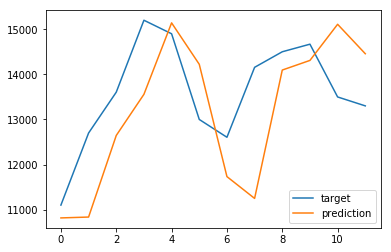

In [29]:
import matplotlib.pyplot as plt
target = np.exp(scaler.inverse_transform(x[-ahead:].reshape(-1,1)))
plt.plot(target)
plt.plot(pred1)
plt.legend(['target','prediction'])